This notebook prepares a planet candidate catalog for the stellar population in the specified input stellar catalog.  It computes the reliability, corrected planet radius and includes useful planet properties such as robovetter score.  It outputs two catalogs, one that contains only PCs and one that contains all KOIs.

Reliability is given by

$$ R = \frac{N_{\mathrm{truePC}}}{N_{\mathrm{obsPC}}} = 1 - \frac{N_{\mathrm{obsFP}}}{N_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{F_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) $$

where $E = N_{\mathrm{obsFP}}/N_{\mathrm{trueFP}}$ is the false positive effectiveness, $F_{\mathrm{obsFP}} = N_{\mathrm{obsFP}}/N_{\mathrm{obsTCEs}}$ is the fraction of observed TCEs that are dispositioned as FP and $F_{\mathrm{obsPC}} = N_{\mathrm{obsPC}}/N_{\mathrm{obsTCEs}}$ is the fraction of TCEs dispositioned as PC.

We will separately measure $E$ and $F_{\mathrm{obsFP}}$ as binomial point processes with probabilities that depend on period and MES.  Once we have $F_{\mathrm{obsFP}}$ then $F_{\mathrm{obsPC}} = 1 - F_{\mathrm{obsFP}}$, assuming that $N_{\mathrm{obsTCEs}} = N_{\mathrm{obsPC}} + N_{\mathrm{obsFP}}$.

We think of TCEs as consisting of two sets: those that are dispositioned as FP and those that are dispositioned as PC.  We do this for both the observed TCEs, and for inverted/scrambled TCEs, where all TCEs are true false positives.  Then we can think of the vetting process as drawing from the set of TCEs, with a probability $r$ of selecting either PCs or FPs.  Then the probability distribution of selecting $c$ FPs from $n$ TCEs is given by the binomial distribution

$$P\{c\} = \left( \begin{array}{c} n \\ c \end{array} \right) r^c (1-r)^{n-c}.$$

To measure $E$ we use the inverted and scrambled data sets, where all detected TCEs are by definition FPs.  We define $E$ as the probability of drawing FPs from inverted/scrambled TCEs, found via the Bayesian inference $p(E|n, c) \propto p(c|E, n) p(E)$, where 
$$p(c|E, n) = \left( \begin{array}{c} n \\ c \end{array} \right) E^c (1-E)^{n-c}$$ and
$p(E)$ is a prior distribution of the probability $E$.  By putting the data on a grid indexed by $i,j$, we can fit effectiveness as a function parameterized by a vector $\theta$, $E(\theta,\mathrm{period},\mathrm{MES})$, as $p(\theta)|n_{i,j}, c_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) \propto p(c_{i,j}|\theta, n_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) p(\theta)$, where $p(\theta)$ is some prior distribution of the parameters.

To measure $F_{\mathrm{obsFP}}$ we perform a similar inference using the set of observed TCEs, and inferring the probability of drawing c FPs from n observed TCEs.  The inference in this case becomes $p(F_{\mathrm{obsFP}}|n, c) \propto p(c|F_{\mathrm{obsFP}}, n) p(F_{\mathrm{obsFP}})$, which we can parameterize interms of a function similar to effectiveness.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
import pandas as pd
from astropy.io import ascii
from astropy.table import Table, vstack
import pickle
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm

import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

Reliability is given by

$$ R = \frac{N_{\mathrm{truePC}}}{N_{\mathrm{obsPC}}} = 1 - \frac{N_{\mathrm{obsFP}}}{N_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{F_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{1 - F_{\mathrm{obsFP}}} \left( \frac{1 - E}{E} \right) $$

where $E = N_{\mathrm{obsFP}}/N_{\mathrm{trueFP}}$, $F_{\mathrm{obsFP}} = N_{\mathrm{obsFP}}/N_{\mathrm{obsTCEs}}$ is the fraction of observed TCEs that are dispositioned as FP and $F_{\mathrm{obsPC}} = N_{\mathrm{obsPC}}/N_{\mathrm{obsTCEs}}$ is the fraction of TCEs dispositioned as PC.

We get $E$ and $F_{\mathrm{obsFP}}$ from the outputs of the notebooks binomialFPEffectiveness.ipynb and binomialObsFPRate.ipynb.

In [2]:
catalogType = "BergerRadCut"
# catalogType = "Berger2019"
# catalogType = "BergerRadCut"
# catalogType = "Burke"

# set the effectiveness model
fpEffModel = "rotatedLogisticX0"
# set the obs FP rate model
obsModel = "rotatedLogisticX0"

# read in the model parameters
tt = pd.read_pickle("fpEffectivenessTable.pkl")
tm = tt[tt.Model == fpEffModel]
fpEffXRange = tm.periodRange.values[0]
fpEffYRange = tm.mesRange.values[0]
fpEffTheta = tm.medianMCMCTheta.values[0] 

tt = pd.read_pickle("obsFpTable.pkl")
tm = tt[tt.Model == obsModel]
obsXRange = tm.periodRange.values[0]
obsYRange = tm.mesRange.values[0]
obsTheta = tm.medianMCMCTheta.values[0] 


In [3]:
cellPeriod, cellMes = np.meshgrid(np.array(np.linspace(fpEffXRange[0], fpEffXRange[1], 200)), 
                          np.array(np.linspace(fpEffYRange[0], fpEffYRange[1], 200)))

effFit = funcModels.evaluateModel(cellPeriod, cellMes, fpEffTheta, fpEffXRange, fpEffYRange, fpEffModel)
obsFit = funcModels.evaluateModel(cellPeriod, cellMes, obsTheta, obsXRange, obsYRange, obsModel)

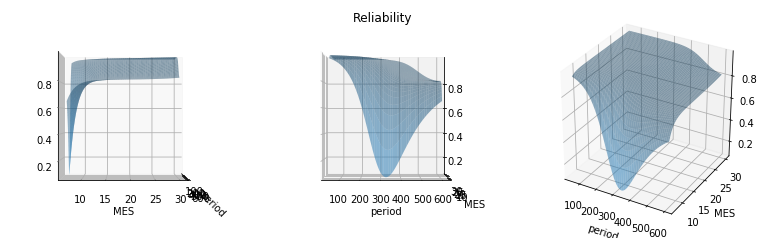

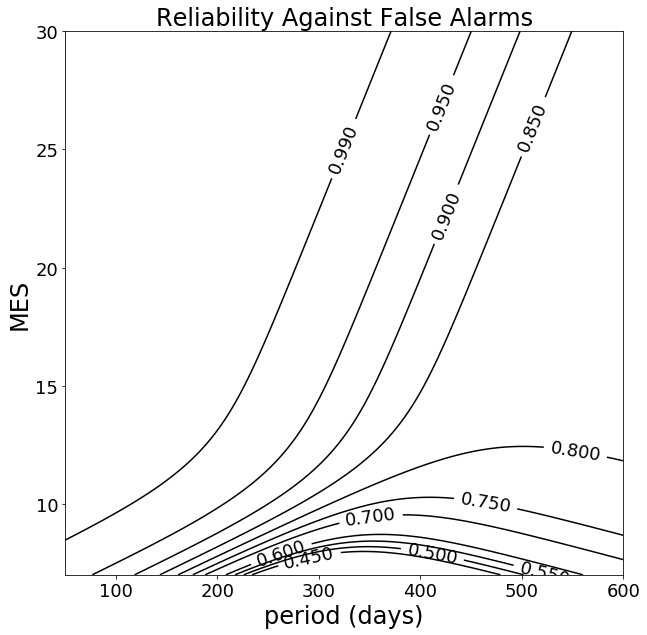

In [4]:
fig = plt.figure(figsize=plt.figaspect(0.3));
R = 1 - (obsFit/(1-obsFit))*((1-effFit)/effFit)

pR = R;
pR[pR<0] = 0;

ax = fig.add_subplot(1, 3, 1, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,0)

ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,-90)
plt.title("Reliability");

ax = fig.add_subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");


fig, ax = plt.subplots(figsize=(10,10));
CS = ax.contour(cellPeriod, cellMes, pR, colors='k', levels = [.45, .5, .55, .6, .7, .75, .8, .85, .9, .95, .99]);
ax.clabel(CS, inline=1, fontsize=18);
ax.tick_params(axis = "both", labelsize = 18)
plt.xlabel("period (days)", fontsize = 24);
plt.ylabel("MES", fontsize = 24);
plt.savefig("reliabilityContours.pdf",bbox_inches='tight')
plt.title("Reliability Against False Alarms", fontsize = 24);





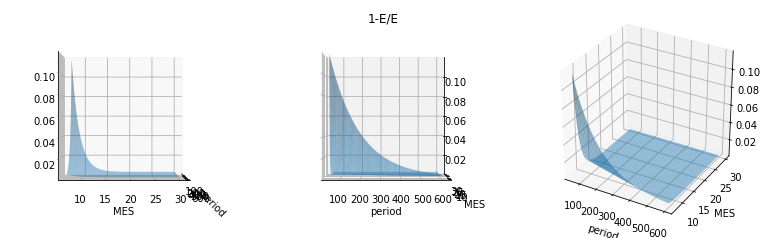

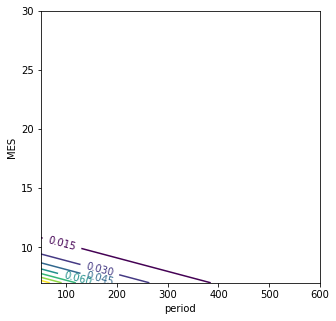

In [5]:
fig = plt.figure(figsize=plt.figaspect(0.3));
R = (1-effFit)/effFit

pR = R;
pR[pR<0] = 0;

ax = fig.add_subplot(1, 3, 1, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,0)

ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,-90)
plt.title("1-E/E");

ax = fig.add_subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");


fig, ax = plt.subplots(figsize=(5,5));
CS = ax.contour(cellPeriod, cellMes, pR);
ax.clabel(CS, inline=1, fontsize=10);
plt.xlabel("period");
plt.ylabel("MES");



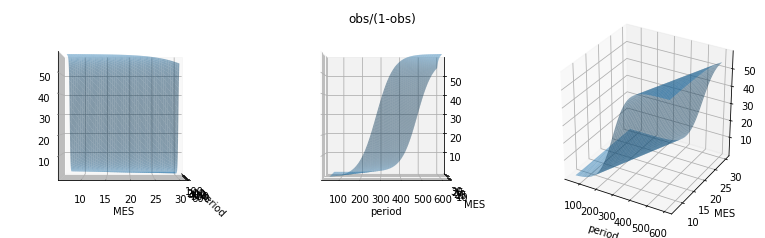

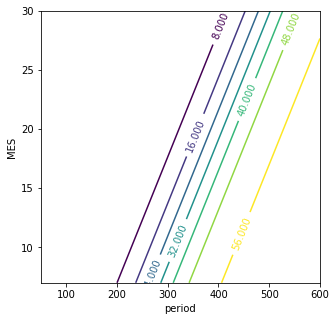

In [6]:
fig = plt.figure(figsize=plt.figaspect(0.3));
R = obsFit/(1-obsFit)

pR = R;
pR[pR<0] = 0;

ax = fig.add_subplot(1, 3, 1, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,0)

ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,-90)
plt.title("obs/(1-obs)");

ax = fig.add_subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");


fig, ax = plt.subplots(figsize=(5,5));
CS = ax.contour(cellPeriod, cellMes, pR);
ax.clabel(CS, inline=1, fontsize=10);
plt.xlabel("period");
plt.ylabel("MES");





/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([[       nan, 0.99980999, 0.95908385],
       [       nan, 0.99680568, 0.8944732 ],
       [       nan, 0.94256453, 0.60988632]])

<Figure size 216x216 with 0 Axes>

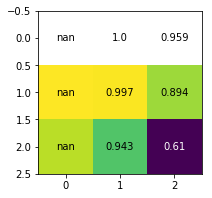

In [7]:
R = 1 - (obsFit/(1-obsFit))*((1-effFit)/effFit)

pR = R;
pR[pR<0] = 0;

sp = np.zeros([3,3])
sPeriod = np.array([[0, 10, 200], [0, 10, 200], [0, 10, 200]])
sMes = np.array([[0, 0, 0], [10, 10, 10], [30, 30, 30]])
sp[0,0] = np.mean(np.mean(pR[np.where((cellPeriod > 0) & (cellPeriod <= 20) & (cellMes > 20) & (cellMes <= 200))]))
sp[0,1] = np.mean(np.mean(pR[np.where((cellPeriod > 20) & (cellPeriod <= 200) & (cellMes > 20) & (cellMes <= 200))]))
sp[0,2] = np.mean(np.mean(pR[np.where((cellPeriod > 200) & (cellPeriod <= 500) & (cellMes > 20) & (cellMes <= 200))]))

sp[1,0] = np.mean(np.mean(pR[np.where((cellPeriod > 0) & (cellPeriod <= 20) & (cellMes > 10) & (cellMes <= 20))]))
sp[1,1] = np.mean(np.mean(pR[np.where((cellPeriod > 20) & (cellPeriod <= 200) & (cellMes > 10) & (cellMes <= 20))]))
sp[1,2] = np.mean(np.mean(pR[np.where((cellPeriod > 200) & (cellPeriod <= 500) & (cellMes > 10) & (cellMes <= 20))]))

sp[2,0] = np.mean(np.mean(pR[np.where((cellPeriod > 0) & (cellPeriod <= 20) & (cellMes > 0) & (cellMes <= 10))]))
sp[2,1] = np.mean(np.mean(pR[np.where((cellPeriod > 20) & (cellPeriod <= 200) & (cellMes > 0) & (cellMes <= 10))]))
sp[2,2] = np.mean(np.mean(pR[np.where((cellPeriod > 200) & (cellPeriod <= 500) & (cellMes > 0) & (cellMes <= 10))]))

x = np.array([[0, 1, 2], [0, 1, 2], [0, 1, 2]])
y = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2]])
dx = 1
dy = 1
imageSize = (3,3)
plt.figure(figsize=imageSize);
fig, ax = plt.subplots(figsize=imageSize);
da = np.transpose(sp);
ax.imshow(da);
# ax.imshow(da, origin='lower');
arrayShape = da.shape;
for i in range(arrayShape[0]):
    for j in range(arrayShape[1]):
        if da[i, j] < 0.7:
            c = "w"
        else:
            c = "k"
        text = ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, round(da[i, j],3),
                       ha="center", va="center", color=c);

sp



In [8]:
def computeReliabiltyPosterior(xp, yp, eSamples, oSamples):
    r = np.zeros(np.shape(eSamples)[0])
    for i in range(np.shape(eSamples)[0]):
        e = funcModels.evaluateModel(xp, yp, eSamples[i,:], fpEffXRange, fpEffYRange, fpEffModel)
        o = funcModels.evaluateModel(xp, yp, oSamples[i,:], obsXRange, obsYRange, obsModel)
        r[i] = 1 - (o/(1-o))*((1-e)/e)

    e = funcModels.evaluateModel(xp, yp, fpEffTheta, fpEffXRange, fpEffYRange, fpEffModel)
    o = funcModels.evaluateModel(xp, yp, obsTheta, obsXRange, obsYRange, obsModel)
    f = 1 - (o/(1-o))*((1-e)/e)

    return r, f

In [9]:
eSamples = np.load("binEffPosteriors_" + str(fpEffModel) + ".npy");
oSamples = np.load("binObsPosteriors_" + str(obsModel) + ".npy");

r1, f1 = computeReliabiltyPosterior(200., 25., eSamples, oSamples)
r2, f2 = computeReliabiltyPosterior(365., 10., eSamples, oSamples)
r3, f3 = computeReliabiltyPosterior(365., 8., eSamples, oSamples)




f1:0.9994323312674375
f2:0.7424431005551173
f3:0.46196912771177545


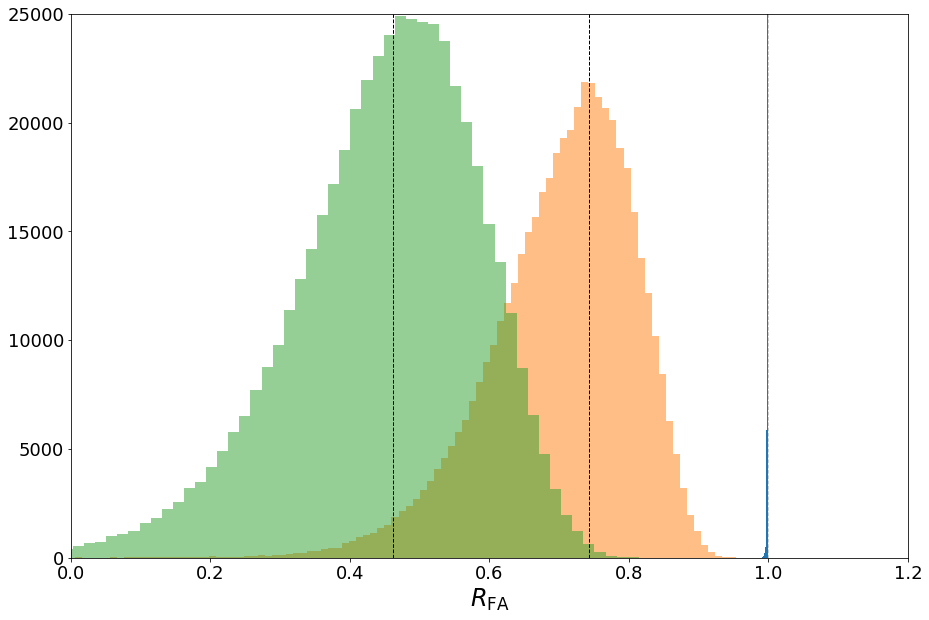

In [10]:
ymax = 25000
plt.figure(figsize=(15,10))
plt.hist(r1, 20);
plt.plot([f1, f1], [0, ymax], color='k', linestyle='--', linewidth=1, alpha = 0.2)

plt.hist(r2, 100, alpha = 0.5);
plt.plot([f2, f2], [0, ymax], color='k', linestyle='--', linewidth=1, alpha = 1)

plt.hist(r3, 100, alpha = 0.5);
plt.plot([f3, f3], [0, ymax], color='k', linestyle='--', linewidth=1, alpha = 1)
plt.ylim(0, ymax)
plt.xlim(0, 1.2)
plt.tick_params(labelsize = 18)
plt.xlabel("$R_\mathrm{FA}$", fontSize = 24);

plt.savefig("reliabilityExamples.pdf",bbox_inches='tight')

print("f1:" + str(f1))
print("f2:" + str(f2))
print("f3:" + str(f3))


In [11]:
import requests
from cStringIO import StringIO
if False:
    selectStr = "kepid,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,koi_ror,koi_ror_err1,koi_ror_err2"
    urlDr25Koi = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr25_koi&select=" + selectStr

    r = requests.get(urlDr25Koi)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    dr25Koi = pd.read_csv(fh, dtype={"kepoi_name":str})
    dr25Koi.to_csv("koiCatalogs/dr25_kois_archive.txt", index=False)
else:
    dr25Koi = pd.read_csv("koiCatalogs/dr25_kois_archive.txt", dtype={"kepoi_name":str})

print("Loaded " + str(len(dr25Koi)) + " KOIs")





Loaded 8054 KOIs


In [12]:
# restrict the population to stars in the Travis' catalog

if catalogType == "Berger2019":
    dr25CleanStellarIso = pd.read_csv("../stellarCatalogs/dr25_stellar_berger2019_clean_GK.txt")
if catalogType == "BergerRadCut":
    dr25CleanStellarIso = pd.read_csv("../stellarCatalogs/dr25_stellar_berger2019_clean_GaiaRadCut_GK.txt")
elif catalogType == "Burke":
    dr25CleanStellarIso = pd.read_csv("../stellarCatalogs/dr25_stellar_supp_burke_clean_GK.txt")
dr25Koi = dr25Koi[dr25Koi.kepid.isin(dr25CleanStellarIso.kepid)]
dr25Koi = dr25Koi.reset_index(drop=True)
print("After removing planets not in Travis' list, we have " + str(len(dr25Koi)) + " KOIs")


After removing planets not in Travis' list, we have 2804 KOIs


In [13]:
# merge in only iso_rad and uncertainties from the stellar table

dr25Koi = pd.merge(dr25Koi, dr25CleanStellarIso[["kepid","radius","radius_err1","radius_err2","teff"]], on="kepid", how="inner")


In [14]:
# correct the planet radii with the new catalog

rEarth = 6356.8 # km
rSun = 695700 # km

dr25Koi['corrected_prad'] = dr25Koi['koi_ror']*dr25Koi['radius']*rSun/rEarth;
dr25Koi['corrected_prad_err1'] = np.sqrt(dr25Koi['koi_ror_err1']**2*dr25Koi['radius']**2
                                        +dr25Koi['koi_ror']**2*dr25Koi['radius_err1']**2)*rSun/rEarth;
dr25Koi['corrected_prad_err2'] = -np.sqrt(dr25Koi['koi_ror_err2']**2*dr25Koi['radius']**2
                                        +dr25Koi['koi_ror']**2*dr25Koi['radius_err2']**2)*rSun/rEarth;

dr25Koi = dr25Koi[~np.isnan(dr25Koi.koi_prad)]

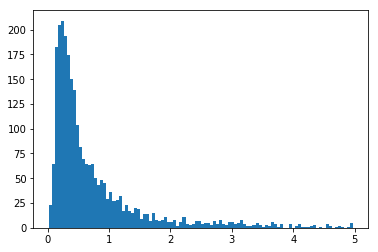

In [15]:
v = dr25Koi.corrected_prad_err1/dr25Koi.koi_prad_err1
plt.hist(v[v<5], 100);

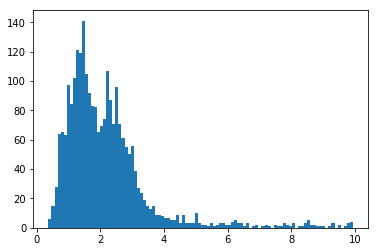

In [16]:
plt.hist(dr25Koi['corrected_prad'][dr25Koi['corrected_prad']<10], 100);

(50, 400)

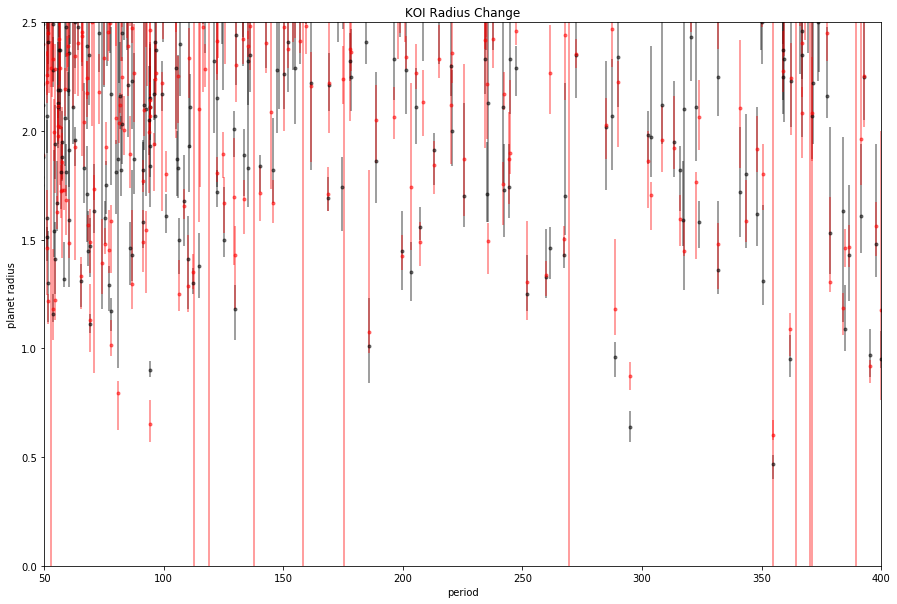

In [17]:
fig, ax = plt.subplots(figsize=(15,10));
ax.errorbar(dr25Koi.koi_period, dr25Koi.koi_prad, 
            yerr = [-dr25Koi.koi_prad_err2, dr25Koi.koi_prad_err1],
            fmt="k.", alpha = 0.5);
ax.errorbar(dr25Koi.koi_period, dr25Koi.corrected_prad, 
            yerr = [-dr25Koi.corrected_prad_err2, dr25Koi.corrected_prad_err1],
            fmt="r.", alpha = 0.5);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Radius Change");
plt.ylim([0, 2.5])
plt.xlim([50, 400])



In [18]:
dr25Fpp = ascii.read("../data/q1_q17_dr25_koifpp.txt")
dr25FppPd = dr25Fpp.to_pandas()

In [19]:
mergedDr25Koi = pd.merge(dr25Koi, dr25FppPd, on="kepoi_name", how="inner")



In [20]:
mergedDr25Koi.loc[:,"fpEffectiveness"] = pd.Series(
                            funcModels.evaluateModel(mergedDr25Koi.koi_period,
                             mergedDr25Koi.koi_max_mult_ev, fpEffTheta, 
                             fpEffXRange, fpEffYRange, fpEffModel), index = mergedDr25Koi.index)
mergedDr25Koi.loc[:,"obsFpRate"] = pd.Series(
                            funcModels.evaluateModel(mergedDr25Koi.koi_period,
                             mergedDr25Koi.koi_max_mult_ev, obsTheta, 
                             obsXRange, obsYRange, obsModel), index = mergedDr25Koi.index)

mergedDr25Koi.loc[:,"reliability"] = pd.Series(
    1-(mergedDr25Koi.obsFpRate/(1-mergedDr25Koi.obsFpRate))
    *(1-mergedDr25Koi.fpEffectiveness)/mergedDr25Koi.fpEffectiveness, index = mergedDr25Koi.index)
    
mergedDr25Koi.reliability[mergedDr25Koi.reliability < 0.] = 0.

/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


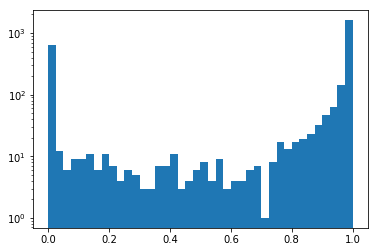

In [21]:
plt.hist(mergedDr25Koi.koi_score, 40);
plt.yscale('log', nonposy='clip')



In [22]:
np.sum(np.isnan(mergedDr25Koi.fpp_prob) & mergedDr25Koi.koi_period > 50)

0

In [23]:
mergedDr25Koi[np.abs(mergedDr25Koi.koi_period - mergedDr25Koi.fpp_koi_period)>1e-2]

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,corrected_prad,corrected_prad_err1,corrected_prad_err2,rowid,kepid_y,fpp_koi_period,fpp_prob,fpEffectiveness,obsFpRate,reliability
2152,9394762,K05664.01,1,FALSE POSITIVE,0.0,77.138911,11.215458,3.39,1.02,-0.27,...,3.427388,22.922429,-1.060969,6112,9394762,308.57,0.68,0.989174,0.168771,0.997778


In [24]:
mergedDr25Koi["fpp_prob_use"] = mergedDr25Koi["fpp_prob"]
mergedDr25Koi.fpp_prob_use[np.isnan(mergedDr25Koi.fpp_prob)] = 1
mergedDr25Koi.fpp_prob_use[np.abs(mergedDr25Koi.koi_period - mergedDr25Koi.fpp_koi_period)>1e-2] = 1



/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
mergedDr25Koi[np.abs(mergedDr25Koi.koi_period - mergedDr25Koi.fpp_koi_period)>1e-2]

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,corrected_prad_err1,corrected_prad_err2,rowid,kepid_y,fpp_koi_period,fpp_prob,fpEffectiveness,obsFpRate,reliability,fpp_prob_use
2152,9394762,K05664.01,1,FALSE POSITIVE,0.0,77.138911,11.215458,3.39,1.02,-0.27,...,22.922429,-1.060969,6112,9394762,308.57,0.68,0.989174,0.168771,0.997778,1.0


In [26]:
mergedDr25Koi["totalReliability"] = (1-mergedDr25Koi.fpp_prob_use)*mergedDr25Koi.reliability

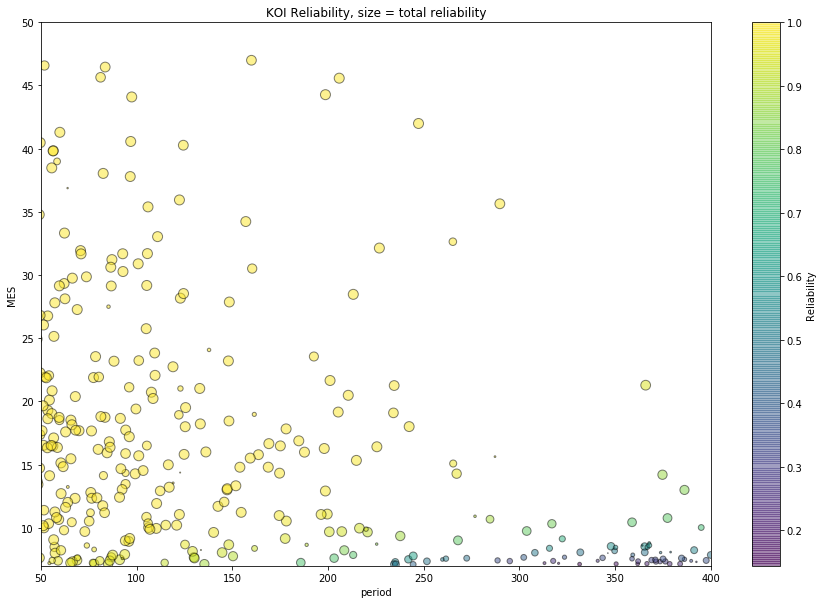

In [27]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.koi_max_mult_ev, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.totalReliability, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
plt.title("KOI Reliability, size = total reliability");
plt.ylim([7, 50])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");



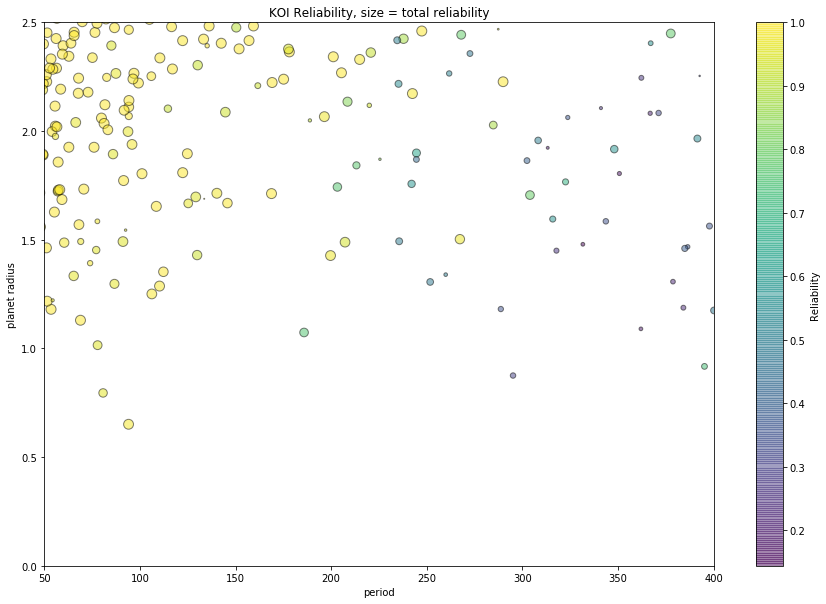

In [28]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.totalReliability, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Reliability, size = total reliability");
plt.ylim([0, 2.5])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");




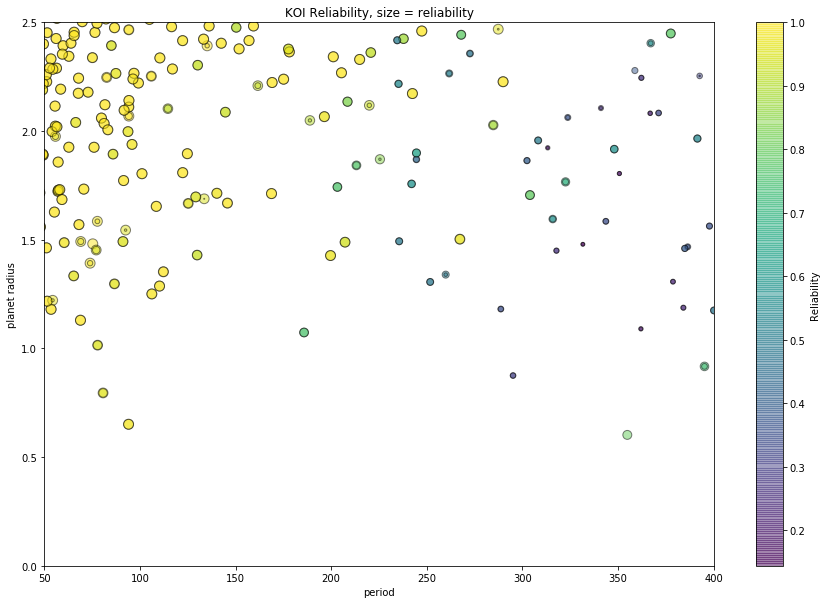

In [29]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.reliability, alpha = 0.5);
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.totalReliability, alpha = 0.5);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Reliability, size = reliability");
plt.ylim([0, 2.5])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");





In [30]:
dr25PC = mergedDr25Koi[mergedDr25Koi.koi_pdisposition == "CANDIDATE"]
dr25FP = mergedDr25Koi[mergedDr25Koi.koi_pdisposition == "FALSE POSITIVE"]
# remove those with corrected_prad = NAN
dr25PC = dr25PC[~np.isnan(dr25PC.corrected_prad)]
dr25FP = dr25FP[~np.isnan(dr25FP.corrected_prad)]
mergedDr25Koi = mergedDr25Koi[~np.isnan(mergedDr25Koi.corrected_prad)]


print("There are " + str(len(dr25PC)) + " PCs in " + str(len(dr25CleanStellarIso)) + " observed targets")
print("There are " + str(len(dr25FP)) + " FPs in " + str(len(dr25CleanStellarIso)) + " observed targets")


There are 2078 PCs in 67306 observed targets
There are 723 FPs in 67306 observed targets


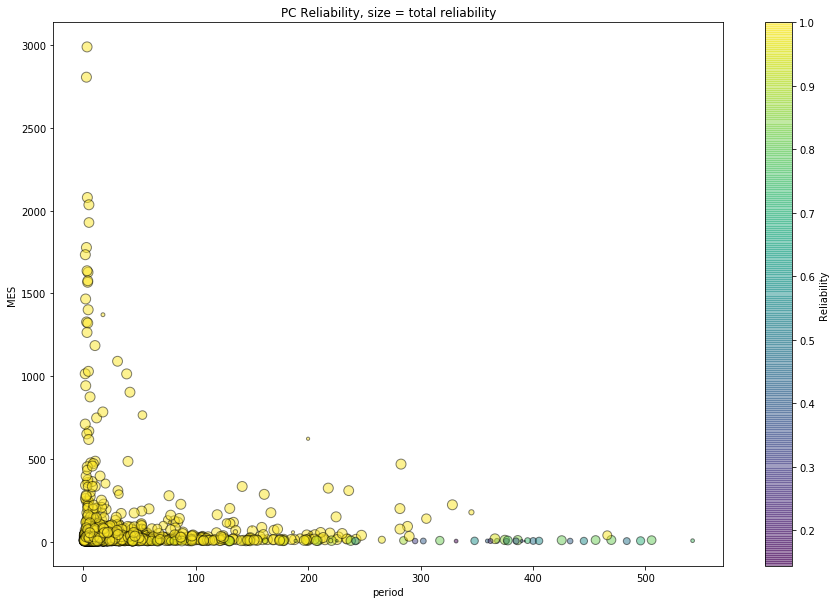

In [31]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.koi_max_mult_ev, cmap="viridis", 
                 c=dr25PC.reliability, edgecolors='k', s=100*dr25PC.totalReliability, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
plt.title("PC Reliability, size = total reliability");
#plt.ylim([7, 30])
#plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");




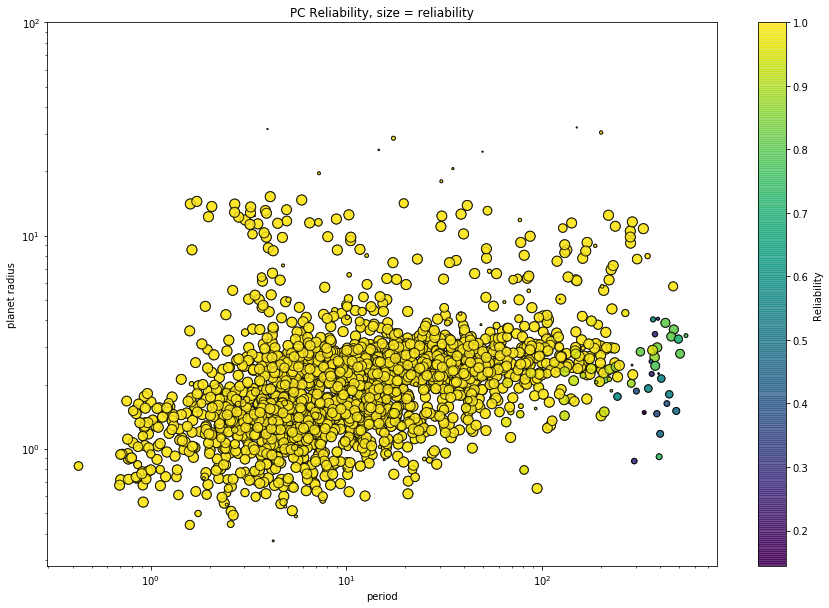

In [32]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, cmap="viridis", 
                 c=dr25PC.reliability, edgecolors='k', s=100*dr25PC.totalReliability, alpha = 0.8);
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, s=100*dr25PC.totalReliability, 
                 c=dr25PC.reliability, facecolors='none', edgecolors='k', alpha = 0.8);
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("PC Reliability, size = reliability");
#plt.ylim([0, 2.5])
#plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");



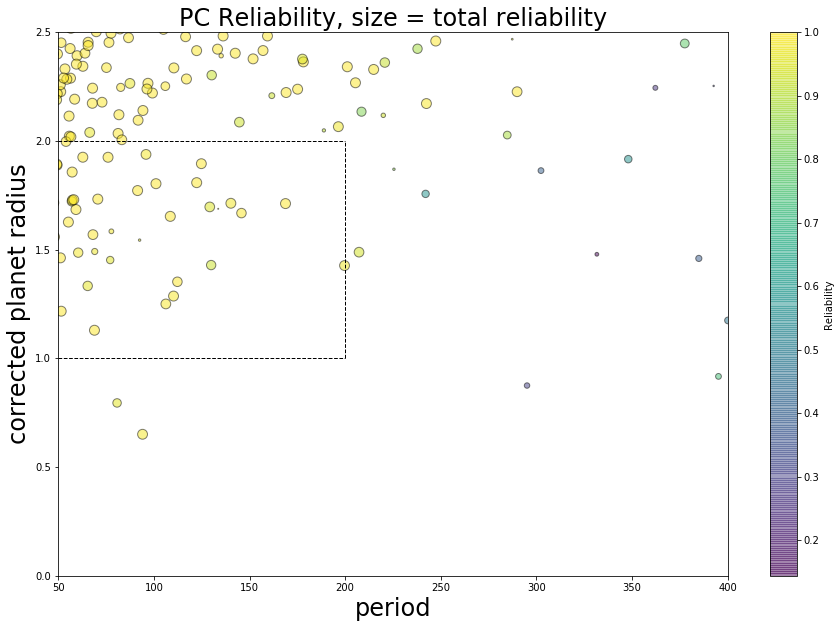

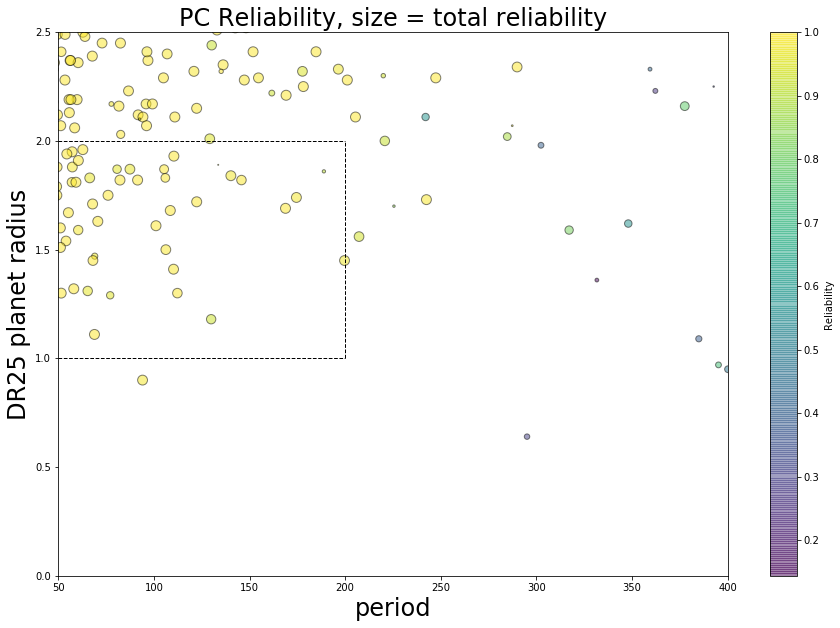

In [33]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, cmap="viridis", 
                 c=dr25PC.reliability, edgecolors='k', s=100*dr25PC.totalReliability, alpha = 0.5);
plt.xlabel("period", fontsize = 24);
plt.ylabel("corrected planet radius", fontsize = 24);
plt.title("PC Reliability, size = total reliability", fontsize = 24);
plt.ylim([0, 2.5])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");
plt.savefig("pcReliability.pdf",bbox_inches='tight')

plt.plot([200, 200], [1, 2], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [1, 1], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [2, 2], color='k', linestyle='--', linewidth=1)

fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.koi_prad, cmap="viridis", 
                 c=dr25PC.reliability, edgecolors='k', s=100*dr25PC.totalReliability, alpha = 0.5);
plt.xlabel("period", fontsize = 24);
plt.ylabel("DR25 planet radius", fontsize = 24);
plt.title("PC Reliability, size = total reliability", fontsize = 24);
plt.ylim([0, 2.5])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");
plt.savefig("pcReliability.pdf",bbox_inches='tight')

plt.plot([200, 200], [1, 2], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [1, 1], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [2, 2], color='k', linestyle='--', linewidth=1)




In [34]:
dr25PcInRange = dr25PC[(dr25PC.koi_period>50)&(dr25PC.koi_period<400)&(dr25PC.corrected_prad>0)&(dr25PC.corrected_prad<2.5)]


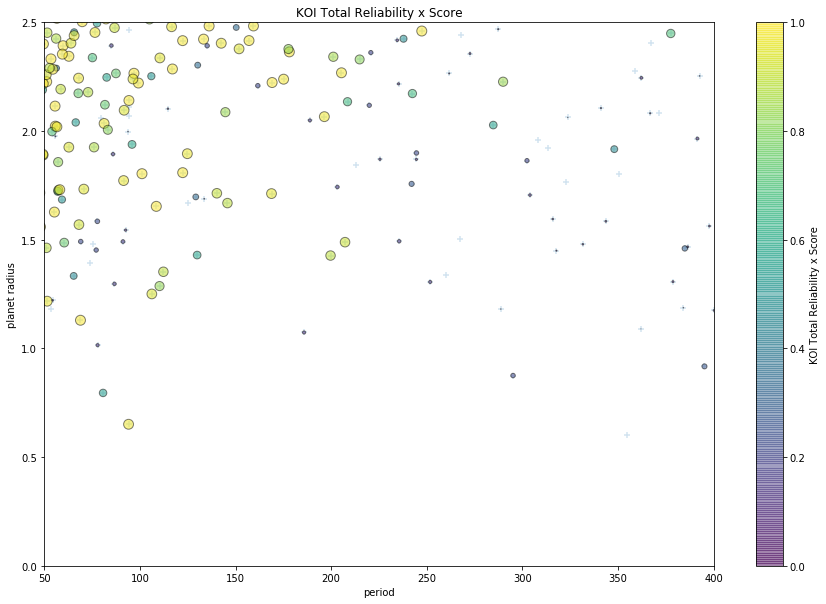

In [35]:
fig, ax = plt.subplots(figsize=(15,10));
rs = mergedDr25Koi.totalReliability*mergedDr25Koi.koi_score
ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, marker="+", alpha=0.2);
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=rs, edgecolors='k', s=100*rs, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Total Reliability x Score");
plt.ylim([0, 2.5])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("KOI Total Reliability x Score");




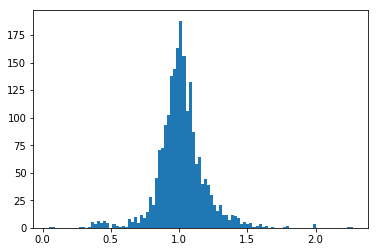

In [36]:
plt.hist(dr25PC.corrected_prad/dr25PC.koi_prad, 100);
#plt.yscale('log', nonposy='clip')



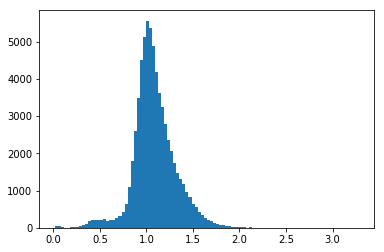

In [37]:
plt.hist(dr25CleanStellarIso.radius[dr25CleanStellarIso.radius<2]/dr25CleanStellarIso.radius_DR25[dr25CleanStellarIso.radius<2], 100);
#plt.yscale('log', nonposy='clip')



In [38]:
dr25PC.to_csv("koiCatalogs/dr25_GK_PCs.csv", index=False)
mergedDr25Koi.to_csv("koiCatalogs/dr25_GK_KOIs.csv", index=False)


(50, 400)

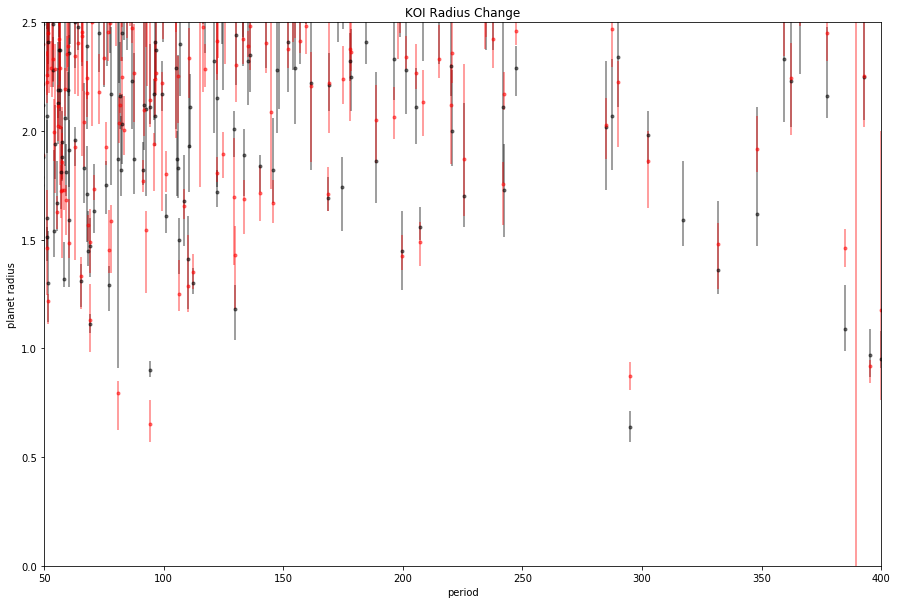

In [39]:
fig, ax = plt.subplots(figsize=(15,10));
ax.errorbar(dr25PC.koi_period, dr25PC.koi_prad, 
            yerr = [-dr25PC.koi_prad_err2, dr25PC.koi_prad_err1],
            fmt="k.", alpha = 0.5);
ax.errorbar(dr25PC.koi_period, dr25PC.corrected_prad, 
            yerr = [-dr25PC.corrected_prad_err2, dr25PC.corrected_prad_err1],
            fmt="r.", alpha = 0.5);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Radius Change");
plt.ylim([0, 2.5])
plt.xlim([50, 400])




Text(0.5,1,'FP score distribution')

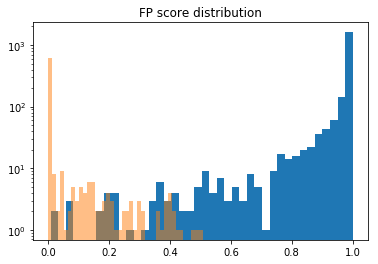

In [40]:
plt.hist(dr25PC.koi_score, 40);
plt.yscale('log', nonposy='clip')
plt.title("PC score distribution")

plt.hist(dr25FP.koi_score, 40, alpha=0.5);
plt.yscale('log', nonposy='clip')
plt.title("FP score distribution")



In [41]:
period_rng = (50, 200)
rp_rng = (1., 2.)

occPcs = dr25PC[(dr25PC.koi_period>=period_rng[0])&(dr25PC.koi_period<=period_rng[1])&(dr25PC.corrected_prad>=rp_rng[0])&(dr25PC.corrected_prad<=rp_rng[1])]
print("After radius correction there are " + str(len(occPcs)) + " PCs in " + str(len(dr25CleanStellarIso)) + " observed targets")
occPcs2 = dr25PC[(dr25PC.koi_period>=period_rng[0])&(dr25PC.koi_period<=period_rng[1])&(dr25PC.koi_prad>=rp_rng[0])&(dr25PC.koi_prad<=rp_rng[1])]
print("Before radius correction there are " + str(len(occPcs2)) + " PCs in " + str(len(dr25CleanStellarIso)) + " observed targets")


After radius correction there are 36 PCs in 67306 observed targets
Before radius correction there are 44 PCs in 67306 observed targets


In [42]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [43]:
%%bash -s "$catalogType"
jupyter nbconvert --to html makePlanetInput.ipynb
mv makePlanetInput.html htmlArchive/makePlanetInput_$1.html

[NbConvertApp] Converting notebook makePlanetInput.ipynb to html
[NbConvertApp] Writing 2028144 bytes to makePlanetInput.html


Text(0,0.5,'instrumental reliability')

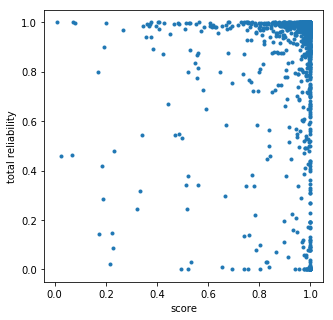

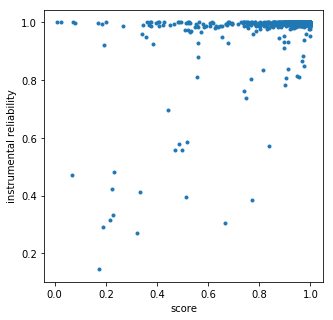

In [44]:
plt.figure(figsize=(5,5));
plt.plot(dr25PC.koi_score, dr25PC.totalReliability, '.')
plt.xlabel("score")
plt.ylabel("total reliability")

plt.figure(figsize=(5,5));
plt.plot(dr25PC.koi_score, dr25PC.reliability, '.')
plt.xlabel("score")
plt.ylabel("instrumental reliability")

In [45]:
print(float((66036-60220))/60220)

0.0965792095649


In [46]:
print((33.-25)/25)

0.32


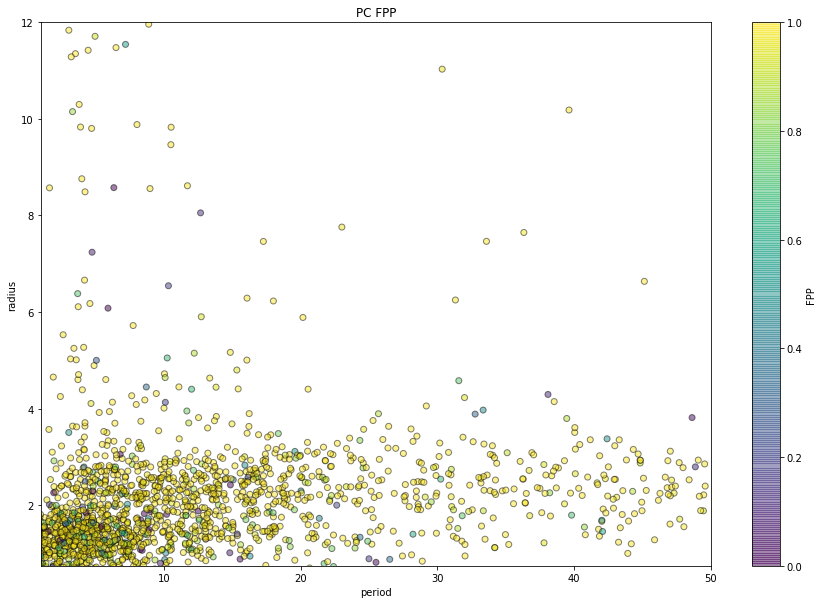

In [47]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, cmap="viridis", 
                 c=1-dr25PC.fpp_prob_use, edgecolors='k', alpha = 0.5);
plt.xlabel("period");
plt.ylabel("radius");
plt.title("PC FPP");
plt.ylim([0.75, 12])
plt.xlim([1, 50])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("FPP");



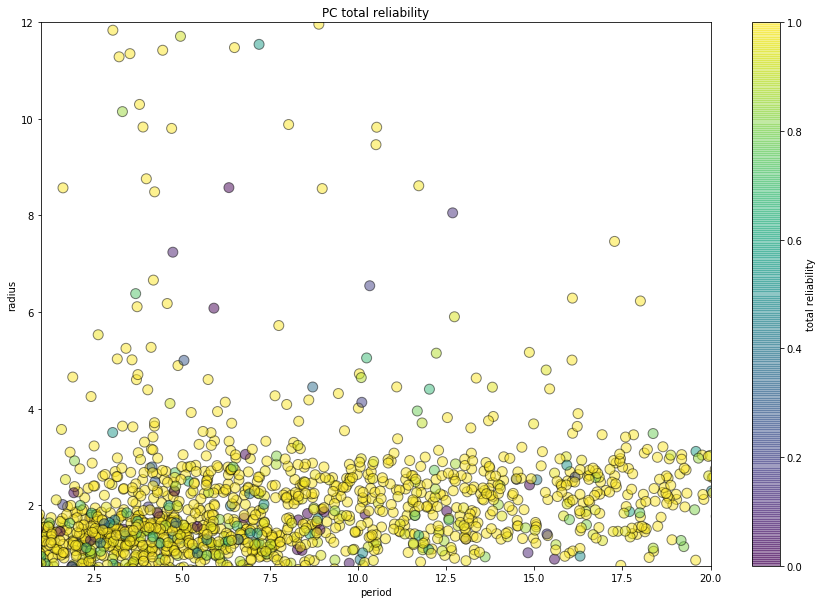

In [48]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, cmap="viridis", 
                 c=dr25PC.totalReliability, edgecolors='k', s=100*dr25PC.reliability, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("radius");
plt.title("PC total reliability");
plt.ylim([0.75, 12])
plt.xlim([1, 20])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("total reliability");



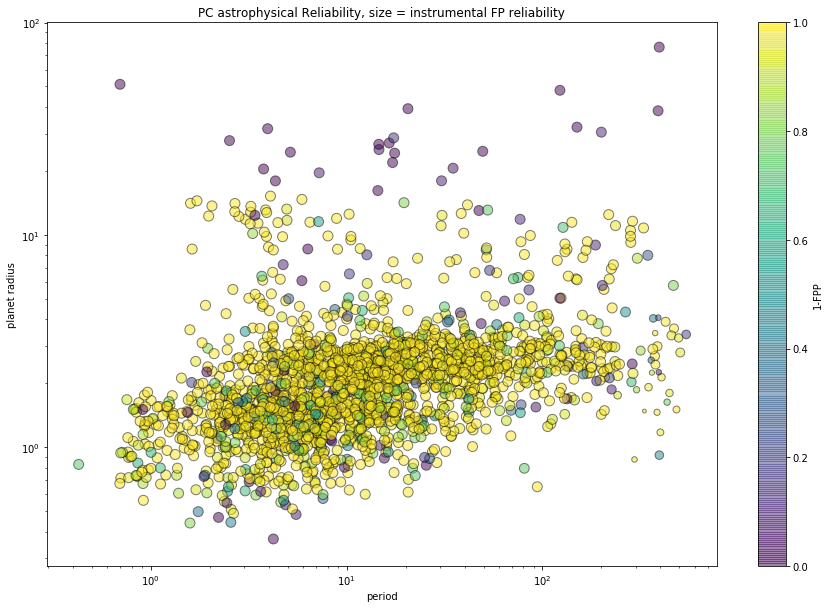

In [49]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, cmap="viridis", 
                 c=1-dr25PC.fpp_prob_use, edgecolors='k', s=100*dr25PC.reliability, alpha = 0.5);
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("PC astrophysical Reliability, size = instrumental FP reliability");
#plt.ylim([0, 2.5])
#plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("1-FPP");



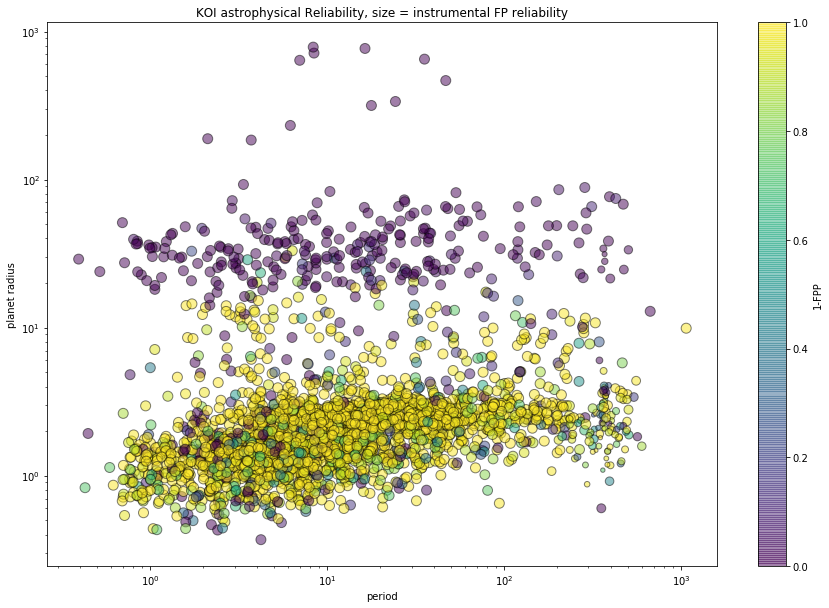

In [50]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=1-mergedDr25Koi.fpp_prob_use, edgecolors='k', s=100*mergedDr25Koi.reliability, alpha = 0.5);
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI astrophysical Reliability, size = instrumental FP reliability");
#plt.ylim([0, 2.5])
#plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("1-FPP");

